# Visual Search
_**Using a Convolutional Neural Net and k-NN to find visually similar items**_

---

---


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [MXNet Model Preparation](#MXNet-Model-Preparation)
1. [Feature Vector Generation](#Feature-Vector-Generation)
1. [Build a Search Index with SageMaker's k-NN Algorithm](#Sagemaker-k-NN)
1. [Host the Index](#Hosting-k-NN)
1. [Evaluate Index Search Results](#Searching-with-Sagemaker-k-NN)
1. [Export the Image Metadata (Optional)](#Export-the-Image-Metadata)
1. [Extensions](#Extensions)


## Background

In this notebook, we'll build the core components of a visual search engine. Visual search is used in interfaces where instead of asking for something by voice or text, you show what you are looking for.

One of the core components of visual search is a convolutional neural net (CNN) model that generates “feature vectors” representing both a query image and the reference item images to be compared against the query. The reference item feature vectors typically are generated offline and must be stored so they can be efficiently searched. For small reference item datasets, it is possible to use a brute force search that compares the query against every reference item. However, this is not feasible for large data sets where brute force search would become prohibitively slow. 

To enable efficient searches for visually similar images, we'll use Amazon SageMaker's k-Nearest Neighbors (k-NN) algorithm. The main objective of training the k-NN algorithm is to construct an index to enable efficient lookups of the "nearest neighbors" of a sample query point. For the use case of visual search, we will use these nearest neighbors directly as the most visually similar matches to the query image. Keep in mind, however, that for use cases other than visual search, the neighbors also can be used for classification (by neighbors' majority vote on class label) or regression (by averaging the neighbors). 

Here are the steps we'll follow to build the visual search engine: After some initial setup, we'll prepare a model using Apache MXNet for generating feature vectors, then generate some feature vectors from a reference item images dataset. Those feature vectors will be used to build a search index using SageMaker's k-NN algorithm. Next, we'll explore some test image queries, and visualize the results.  Finally and optionally, we'll export the feature vectors generated from a test dataset into JSON format so they can be used outside this notebook.


## Setup

Let's start by specifying the S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the SageMaker Notebook Instance, training, and hosting. The IAM role needed for permissions, such as access to data in Amazon S3, is pulled in from the SageMaker Notebook Instance.

In the first line of code, replace the placeholder text with your bucket name, which should be of the form `sagemaker-your-name` or similar beginning with `sagemaker-`. Be sure to remove the angle brackets and keep the quotes. After you have replaced the bucket name, run the cell by clicking the 'Run cell' button in the toolbar above, or using Control + Enter from your keyboard.

In [1]:
bucket = '<sagemaker-your-name>'  
prefix = 'visual-search'
key = 'recordio-pb-data'

import sagemaker as sm

role = sm.get_execution_role()

## MXNet Model Preparation <a class="anchor" id="MXNet-Model-Preparation"></a>

We'll use Apache MXNet to prepare a model for "featurizing" images into feature vectors. One advantage of the approach taken here is that we can start with a pretrained model, avoiding spending time and money training a model from scratch. Accordingly, as a first step in preparing the model, we'll import a pretrained model from the MXNet Model Zoo. Researchers have experimented with various pretrained CNN architectures with different numbers of layers, discovering that there are several good possibilities. 

For this notebook, we'll select a model based on the ResNet architecture, a commonly used choice. Of the various choices for number of layers, ranging from 18 to 152, we'll use 50 layers. This also is a common choice that balances the expressiveness of the resulting feature vectors (embeddings) against computational efficiency (lower number of layers means greater efficiency at the cost of less expressiveness).  

In [2]:
import mxnet as mx

num_layers = 50
resnet = 'resnet-50'

path='http://data.mxnet.io/models/imagenet/'
[mx.test_utils.download(path+'resnet/'+str(num_layers)+'-layers/'+resnet+'-0000.params'),
 mx.test_utils.download(path+'resnet/'+str(num_layers)+'-layers/'+resnet+'-symbol.json')]

sym, arg_params, aux_params = mx.model.load_checkpoint(resnet, 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

Now we'll get a reference to the first fully connected layer of the model, which will become the new output layer that generates feature vectors. More specifically, we'll use that layer to generate a row vector of floating point numbers as an "embedding" or representation of the features of the image. We'll also save the model for potential use outside this notebook.  

In [3]:
all_layers = sym.get_internals()
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

fe_mod.save_checkpoint('featurizer-v1', 0)

---
## Feature Vector Generation <a class="anchor" id="Feature-Vector-Generation"></a>

For purposes of this notebook, a dataset is specified in a text file containing comma-separated (product_title, image_url) tuples.  The following code loops over the tuples specified in the file and creates a list of products ready for feature generation. This involves sending each image through the model and obtaining a feature vector, and putting together a list of the products and their metadata. We also need to preprocess the images to a common shape, which is what the get_image function does.  

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import namedtuple

Batch = namedtuple('Batch', ['data'])

def get_image(fname, show=False):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    
    return img

In [5]:
def process_file(file_name, start_index=0):
    
    products = []
    index = start_index
    dim = 2048
    xb = np.empty(shape=[0, dim], dtype=np.float32)
    
    with open(file_name) as file:
        for line in file:
            product = {}
            fields = line.split(',')
            product['id'] = str(index)
            product['productTitle'] = fields[0].strip()
            product['imageUrl'] = fields[1].strip()
            # download image to be featurized and preprocess it
            file = mx.test_utils.download(product['imageUrl'])
            product['imageFileName'] = file
            img = get_image(file)
            # extract features
            fe_mod.forward(Batch([mx.nd.array(img)]))
            features = fe_mod.get_outputs()[0].asnumpy()
            # the Knn algorithm we'll use requires float32 rather than the default float64
            xb = np.append(xb, features.astype(np.float32), axis=0)
            products.append(product)
            index += 1
            
    return (products, xb)

Now that we've defined a way to featurize images, let's apply it to a small sample of a test dataset. The above function will return a dictionary of product metadata as well as a Numpy matrix where each row corresponds to a reference item's feature vector.

In [6]:
products, train_features = process_file('sample-data.txt')

---
## Build a Search Index with SageMaker's k-NN Algorithm <a class="anchor" id="Sagemaker-k-NN"></a>

The next step is to build a search index to enable fast lookups of visually similar images. For this purpose, we'll use Amazon SageMaker's k-Nearest Neighbors (k-NN) algorithm.

k-NN can be used for both classification and regression tasks. In this use case we're just looking up the nearest neighbors, so we don't need labels for our data for training purposes. However, we need to have a way to identify each feature vector, so we'll supply a dummy set of labels that simply correspond to the row position/id of each reference item. After supplying these "labels", we'll write the data to S3 in recordio-protobuf format for efficiency as required by the algorithm.

In [7]:
import io
import sagemaker.amazon.common as smac

num_instances = train_features.shape[0]
print('number of instances = ', num_instances)
train_labels = np.arange(num_instances)

print('train_features shape = ', train_features.shape)
print('train_labels shape = ', train_labels.shape)

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, train_features, train_labels)
buf.seek(0)

number of instances =  60
train_features shape =  (60, 2048)
train_labels shape =  (60,)


0

In [8]:
import boto3
import os

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-projects-iad/visual-search/train/recordio-pb-data


In SageMaker, training is done via an object called an **Estimator**. When setting up the Estimator we specify the location (in S3) of the training data, the path (again in S3) to the output directory where the model will be serialized, generic hyperparameters such as the training machine type, and k-NN-specific hyperparameters such as the index type. 

Once the Estimator is initialized, we call its `fit` method in order to do the actual training. The function below sets up this Estimator object and runs its fit method. Some parameters are set to specify the training hardware, namely `train_instance_count` (number of machines used for training), and `train_instance_type` (machine type used for training). Since we're only using a small sample dataset at the moment, we'll use CPU compute training hardware of type 'ml.m5.2xlarge', though it may be preferable to use a GPU machine for large datasets.

In [9]:
def trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path, iam_role, s3_test_data=None):

    # specify algorithm containers
    containers = {
        'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/knn:1',
        'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/knn:1',
        'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/knn:1',
        'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/knn:1',
        'ap-northeast-1': '351501993468.dkr.ecr.ap-northeast-1.amazonaws.com/knn:1',
        'ap-northeast-2': '835164637446.dkr.ecr.ap-northeast-2.amazonaws.com/knn:1',
        'ap-southeast-2': '712309505854.dkr.ecr.ap-southeast-2.amazonaws.com/knn:1'
    }
    # set up the estimator
    knn = sm.estimator.Estimator(containers[boto3.Session().region_name],
        iam_role,
        train_instance_count=1,
        train_instance_type='ml.m5.2xlarge',
        output_path=output_path,
        sagemaker_session=sm.Session())
    knn.set_hyperparameters(**hyperparams)
    
    # train a model. fit_input contains the locations of the train and test data
    fit_input = {'train': s3_train_data}
    if s3_test_data is not None:
        fit_input['test'] = s3_test_data
    knn.fit(fit_input)
    
    return knn

We're now ready to launch a SageMaker training job to build the index. First, however, we must specify hyperparameters for the algorithm itself. These include:
-  `k`, the number of neareast neighbors:  for this use case, the value of k is simply the number of visually similar matches we wish to display to end users.
-  `index_metric`, the distance measure for determining nearest neighbors:  for visual search, using the inner product or cosine similarity works better than some other measures such as Euclidean distance (L2).  
-  `index_type`, which determines the specific version of the k-NN algorithm used for training: there are several choices, the one selected here is fine for small datasets, though another type may be better suited for large datasets.  

In [10]:
hyperparams = {
    'feature_dim': 2048,
    'k': 4,
    'predictor_type': 'classifier',
    'index_type': 'faiss.Flat',
    'index_metric': 'INNER_PRODUCT',
    'sample_size': 60
}

output_path = 's3://' + bucket + '/' + prefix + '/output'
knn_estimator = trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path, role, 
                                                           s3_test_data=None)

INFO:sagemaker:Creating training-job with name: knn-2018-08-21-22-17-54-046


....................
Arguments: train
[08/21/2018 22:21:05 INFO 140649961252672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[08/21/2018 22:21:05 INFO 140649961252672] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'index_metric': u'INNER_PRODUCT', u'predictor_type': u'classifier', u'index_type': u'faiss.Flat', u'k': u'4', u'sample_size': u'60', u'feature_dim': u'2048'}
[08/21/2018 22:21:05 INFO 140649961252672] Final configuration: {u'index_metric': u'INNER_PRODUCT', u'predictor_type': u'classifier', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'feat

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sagemaker/session.py:845: DeprecationWarning: generator 'multi_stream_iter' raised StopIteration
  for idx, event in sagemaker.logs.multi_stream_iter(client, log_group, stream_names, positions):


===== Job Complete =====
Billable seconds: 109


---
## Host the Index <a class="anchor" id="Hosting-k-NN"></a>

Next we'll set up an endpoint for the index. This is a simple one-line function call with the SageMaker Python SDK. The `deploy` function creates a SageMaker Model object that wraps the model artifact containing the index, and then deploys that Model to a SageMaker endpoint. It also returns a Predictor object that can be used to make real-time predictions against the SageMaker endpoint. 

In [11]:
knn_predictor = knn_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: knn-2018-08-21-22-21-44-009
INFO:sagemaker:Creating endpoint with name knn-2018-08-21-22-17-54-046


---------------------------------------------------------------------------!

---
## Evaluate Index Search Results <a class="anchor" id="Searching-with-Sagemaker-k-NN"></a>

With our index deployed to a SageMaker endpoint, we're now ready to evaluate some test queries. We'll begin by simply using the first item in the data set as a query image. More specifically, our query will consist of the feature vector of that image. Since the endpoint does not accept raw Numpy ndarray objects as input, first we'll need to convert the feature vector from a Numpy ndarray to an acceptable content type, in this case CSV. We'd also like the endpoint to return its response in JSON format for convenience. For these common formats we can add the SageMaker Python SDK's built in `csv_serializer` and `json_deserializer` functions to the Predictor object returned by the deploy method above.

As a reminder, we're not using k-NN for classification or regression, but rather to retrieve the actual nearest neighbors. SageMaker's k-NN algorithm enables this by allowing specification of `verbose=true` in the Accept header of the Predictor object.

In [12]:
from sagemaker.predictor import csv_serializer, json_deserializer

knn_predictor.content_type = 'text/csv'
knn_predictor.accept = 'application/json; verbose=true'
knn_predictor.serializer = csv_serializer
knn_predictor.deserializer = json_deserializer

Let's send a query using a query item that is in the index as well as the dataset. For the k-NN index_metric hyperparameter, we specified `INNER_PRODUCT`. This means that items more similar to the query item will have a higher inner product value.

In [14]:
query_id = 0
result = knn_predictor.predict(train_features[query_id])
print(result)

{'predictions': [{'distances': [560.1044921875, 561.839599609375, 625.4393310546875, 761.531494140625], 'labels': [8.0, 6.0, 2.0, 0.0], 'predicted_label': 0.0}]}


The verbose output includes the "distances" between the query and the nearest neighbors. Here the distance really is the inner product.  As expected, since the query image is in the index, the inner product of the query image with itself is the highest of the returned neighbors. To visualize the results, we'll need to extract the other labels from the result excluding the query, convert from strings to integer indices, lookup each item's image URL from the metadata, and plot the results. In the plot, the query image is on the left.

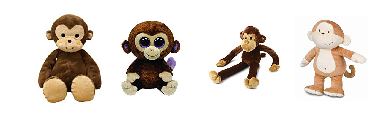

In [15]:
f_nb = (((result['predictions'])[0])['labels'])
ids = [int(e) for e in f_nb if e != query_id]
ids = ids[::-1]
query_object = next((item for item in products if item['id'] == str(query_id)))

fig = plt.figure()
fig.add_subplot(1,4,1)
img = cv2.cvtColor(cv2.imread(query_object['imageFileName']), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

for index, id_num in enumerate(ids):
    product = products[id_num]
    img = cv2.cvtColor(cv2.imread(product['imageFileName']), cv2.COLOR_BGR2RGB)
    fig.add_subplot(1,4,index+2)
    plt.imshow(img)
    plt.axis('off')

To help with the qualitative assessment of the results, let's take a look at a sample of the complete dataset. In this product category, there is a wide variety of colors, shapes, etc. As revealed by a review of this sample, our visual search method did a fairly good job of pulling out the most visually similar reference items.  

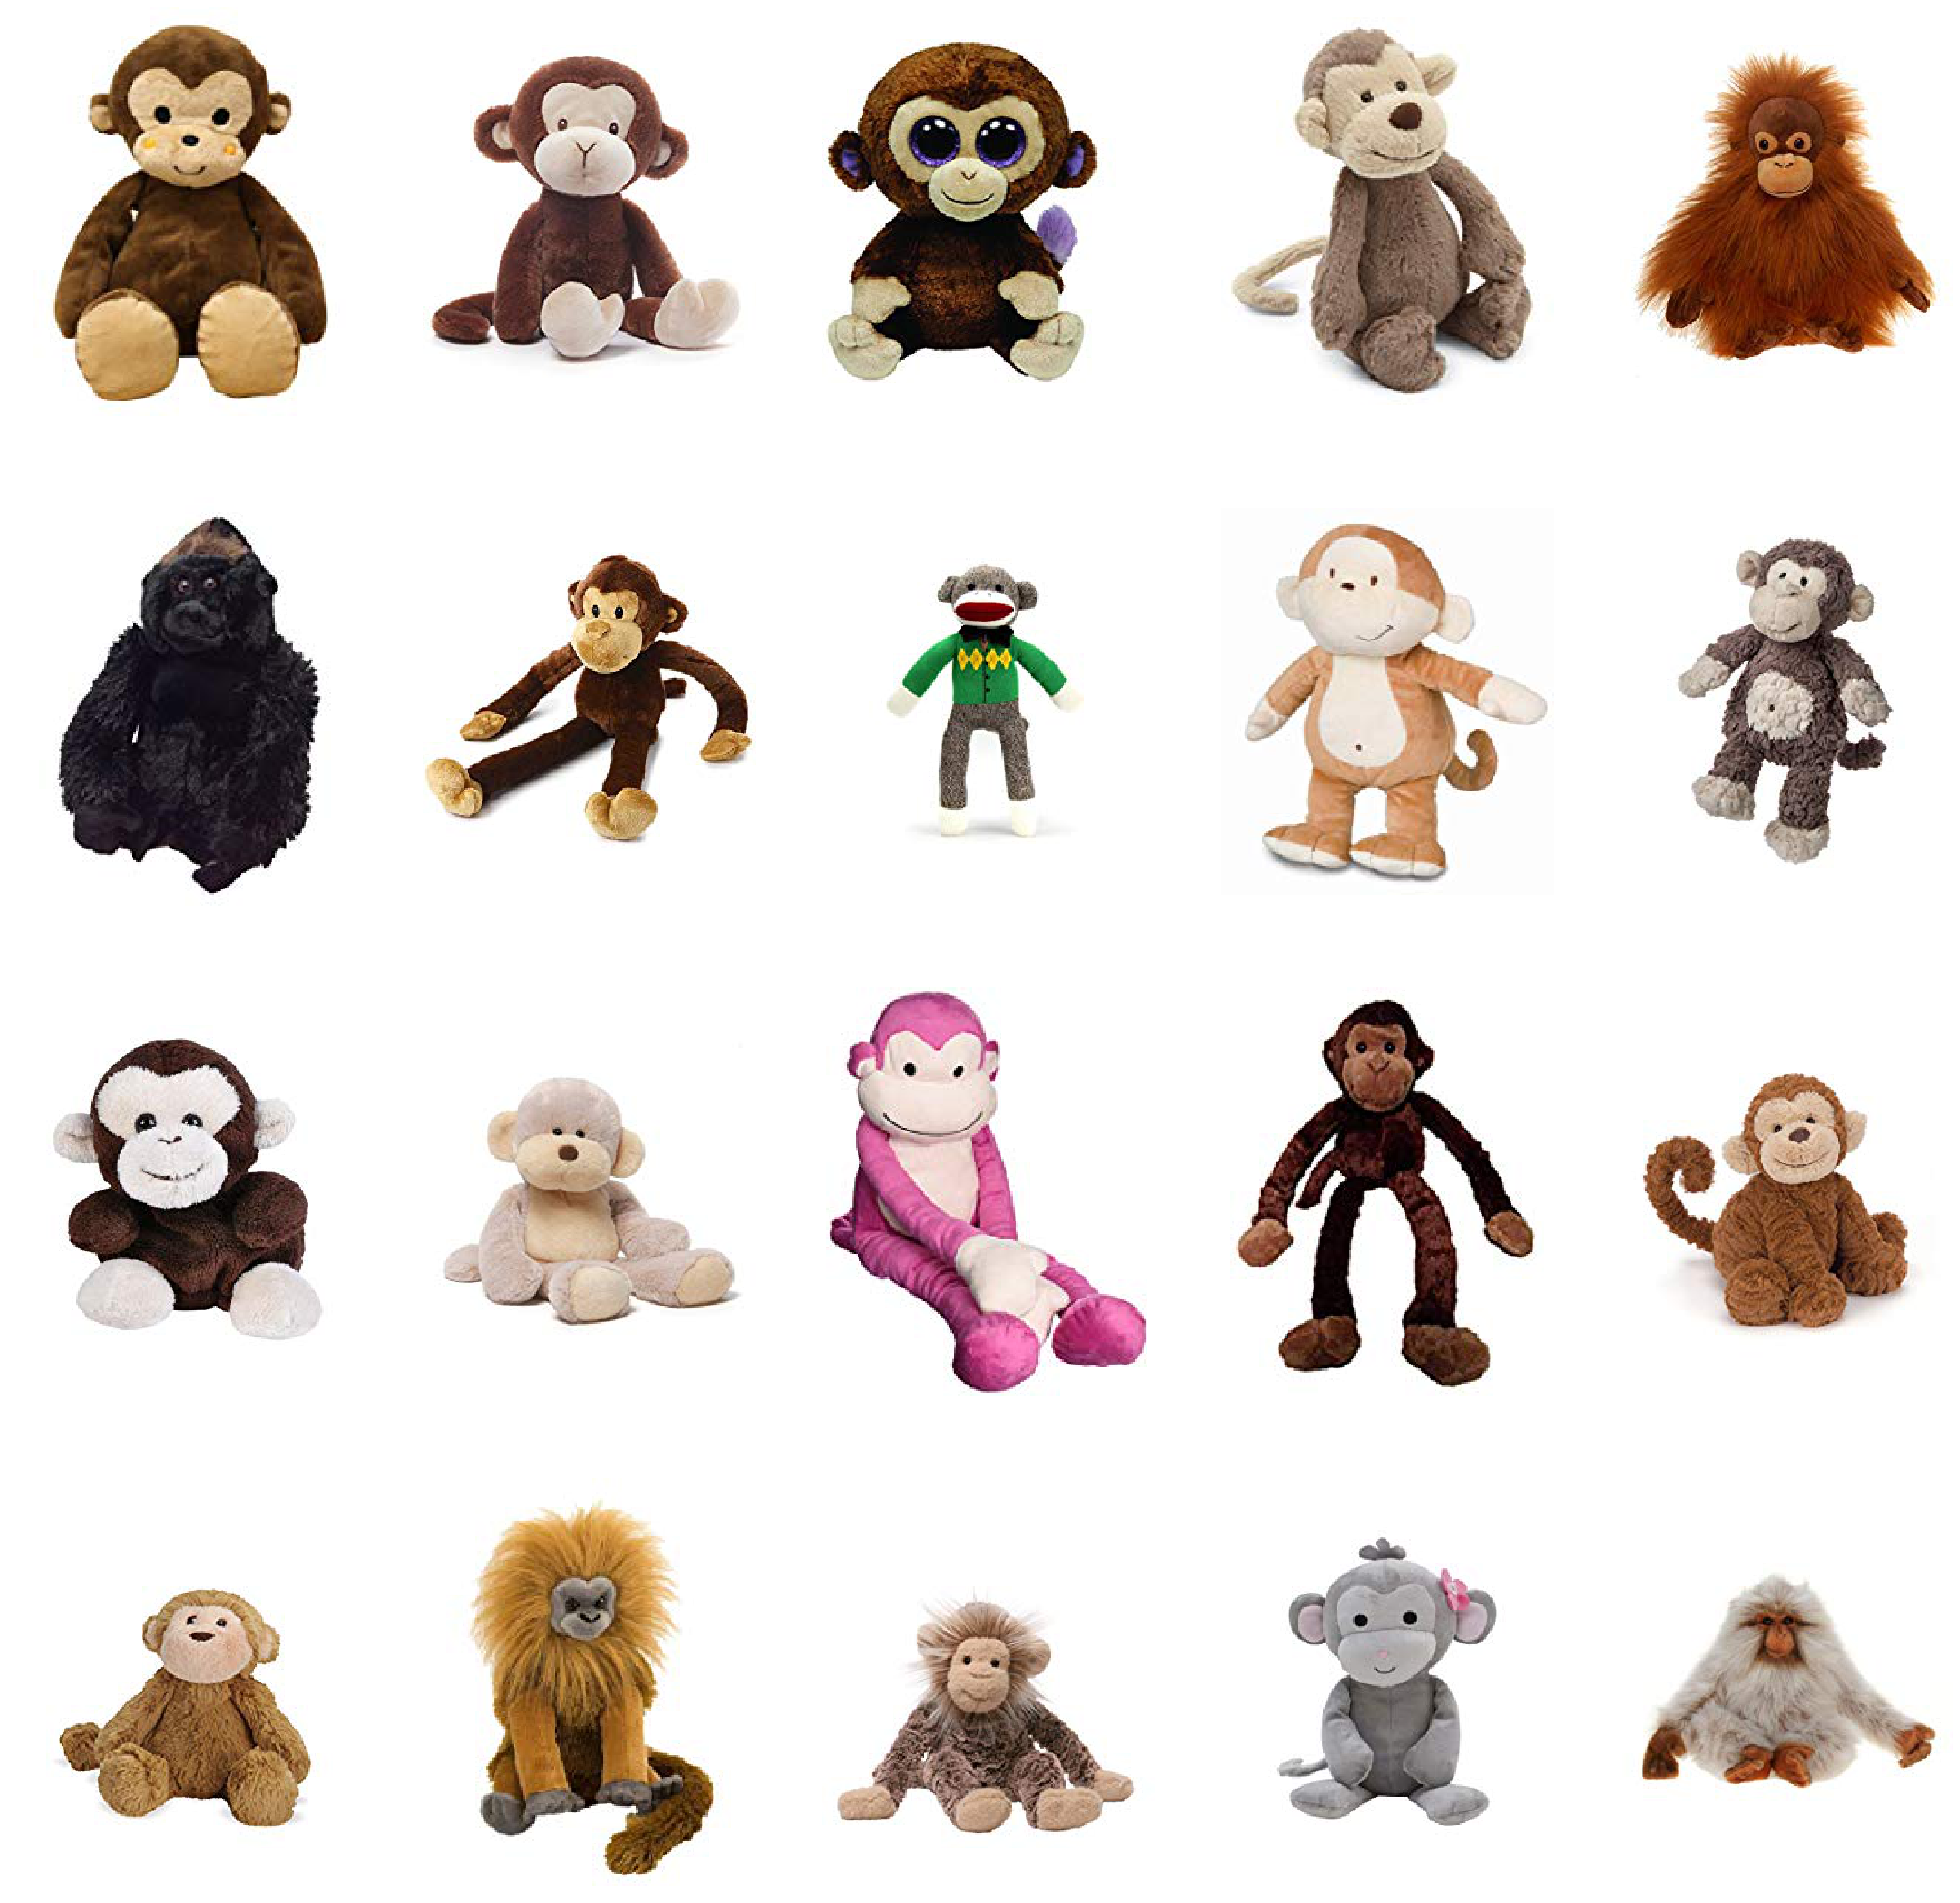

In [16]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(4, 5)

index = 0
for g in gs:
    img_file = products[index]['imageFileName'] 
    _img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
    ax = plt.subplot(g)
    ax.imshow(_img)
    ax.axis('off')
    index += 1

fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)

---
## Export the Image Metadata (Optional) <a class="anchor" id="Export-the-Image-Metadata"></a>

At a minimum, we need at least two things to deploy visual search outside a Jupyter notebook: (1) an index for looking up visually similar matches, and (2) a data store of image metadata. We need the latter because the index only returns the IDs of the matches; the metadata data store allows us to map image IDs returned by index lookups to image URLs and other metadata for displaying results.  We've already built the index.  Now let's prepare the the metadata to be exported to the data store.  

To do so, we'll simply extract the relevant metadata from the products list. Then we'll write the results out in JSON format to a file.  You can then make use of the metadata, for example by using a script to import them to DynamoDB for use by a search Lambda function.

In [17]:
import json

records = []
for product in products:
    record = {}
    record['id'] = product['id']
    record['title'] = product['productTitle']
    record['url'] = product['imageUrl']
    records.append(record)
    
with open("metadata.json", "w") as f:
    f.write(json.dumps(records))

---
## Extensions <a class="anchor" id="Extensions"></a>

With the index built by SageMaker's k-NN algorithm and a data store for the image metadata, you can deploy visual search in many different scenarios. For example, you could integrate visual search in a web site or in a mobile app. Users could take photos of items and then ask your app to find visually similar items.  

Another possibility is employing visual search in the real, physical world using a device such as AWS DeepLens. In this case, you would deploy to the DeepLens device the same featurizer model used for featurizing the reference items.


## Cleanup

If you do not have any immediate need for the search index, you can run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sm.Session().delete_endpoint(knn_predictor.endpoint)